In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)

from importlib import reload
import sys
sys.path.append('/home/students/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repo/tools')
import plot
import lifeline
import comtools

In [46]:
reload(plot)
reload(lifeline)
reload(comtools)

<module 'comtools' from '/home/students/4302001/arctic-connectivity/tools/comtools.py'>

In [29]:
# Specify paths to velocity field and mesh
# readdir_ocean = '/Users/daanreijnders/Datasets/'
# readdir_ice = '/Users/daanreijnders/Datasets/'
# readdir_mesh = '/Users/daanreijnders/Datasets/'

readdir_ice = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ice/arctic/'
readdir_ocean = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ocean/arctic/'
readdir_mesh = '/scratch/DaanR/fields/'

fieldfile_ocean = 'daily_CESM_0.1degree_controlrun_year_300_arctic_region_timed.nc'
fieldfile_ice = 'monthly_icefields_CESM_0.1degree_controlrun_year_300_arctic.nc'
meshfile = 'POP_grid_coordinates.nc'

writedir = ''

In [30]:
def read_velocity_field(fieldfiles, meshfile=None):
    if not meshfile:
        meshfile = fieldfiles
    filenames = {'U': {'lon': meshfile,
                       'lat': meshfile,
                       'data':fieldfiles},
                 'V': {'lon': meshfile,
                       'lat': meshfile,
                       'data':fieldfiles}}

    variables = {'U': 'UVEL_5m',
                 'V': 'VVEL_5m'}

    dimensions = {'U': {'time': 'time',
                        'lat': 'ULAT',
                        'lon': 'ULON'},
                  'V': {'time': 'time',
                        'lat': 'ULAT',
                        'lon': 'ULON'}}
    fieldset = FieldSet.from_pop(filenames, variables, dimensions, allow_time_extrapolation=False)
    fieldset.U.vmax = 10;  fieldset.U.vmin = -10;  # set max of flow to 10 m/s
    fieldset.V.vmax = 10; fieldset.V.vmin = -10;
    
    fieldset.computeTimeChunk(fieldset.U.grid.time[0], 1)
    fieldset.landMask = np.logical_or(fieldset.U.data[0,:,:]==-0.01, np.abs(fieldset.U.data[0,:,:])<0.0000001)
    return fieldset


# def add_ice_fields(fieldset, fieldfile, iceVars=['aice', 'hisnap', 'hi'], meshfile=None):
#     """Not working for now"""
#     if not meshfile:
#         meshfile = fieldfiles
#     for varName in iceVars:
#         filenames = {'lon': [meshfile],
#                      'lat': [meshfile],
#                      'data': [fieldfile]}
#         variable = (varName, varName)
#         dimensions = {'time': 'time',
#                       'lat': 'TLAT',
#                       'lon': 'TLON'}
#         field = Field.from_netcdf(filenames, variable, dimensions, allow_time_extrapolation=False)
#         fieldset.add_field(field)

In [31]:
# Kernels for circular boundary and for deleting particles as fallback.
def wrapLon(particle, fieldset, time):
    if particle.lon > 180.:
        particle.lon = particle.lon - 360.
    if particle.lon < -180.:
        particle.lon = particle.lon + 360.

def deleteParticle(particle, fieldset, time):
    particle.delete()

In [32]:
# Particle execution function
def gridAdvection(fieldset, \
                  countGrid, \
                  particleGrid, \
                  experiment_name='', \
                  runtime=delta(days=30), \
                  dt = delta(minutes=5), \
                  outputdt = delta(hours = 12)):
    pset = ParticleSet.from_list(fieldset, JITParticle, particleGrid.lonlat[0,:,0], particleGrid.lonlat[0,:,1])
    kernels = pset.Kernel(AdvectionRK4) + pset.Kernel(wrapLon)
    pfile = pset.ParticleFile(name = writedir+"pset_"+experiment_name, outputdt=outputdt)
    print(f"Run: Advecting particles for {runtime}")
    pset.execute(kernels, \
                 runtime = runtime, \
                 dt = dt, \
                 output_file = pfile, \
                 recovery = {ErrorCode.ErrorOutOfBounds: deleteParticle})
    return pset

In [33]:
fieldset = read_velocity_field(readdir_ocean+fieldfile_ocean, meshfile=readdir_mesh+meshfile)  

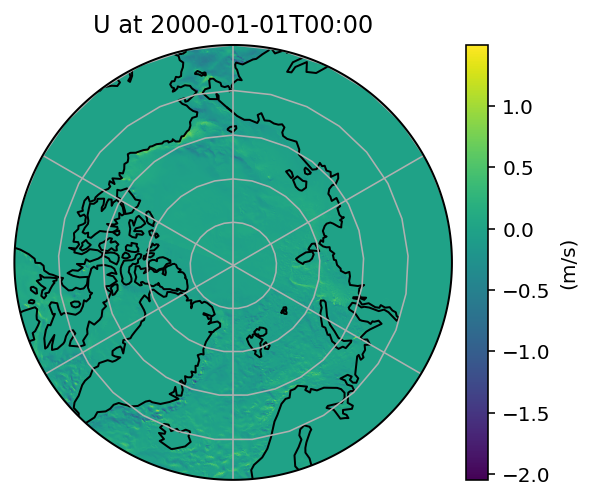

In [34]:
plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90), export='fieldset.U.png')

In [9]:
#add_ice_fields(fieldset, readdir_ice+fieldfile_ice, meshfile=readdir_mesh+meshfile)

In [12]:
countG = comtools.countGrid(240, 40)

In [35]:
particleG = comtools.particleGrid(3590, 590, 0)
particleG.remove_on_land(fieldset)

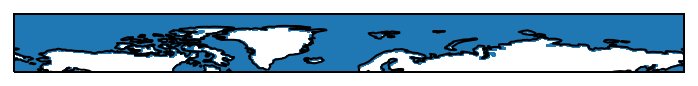

In [14]:
particleG.show(export='pset_init_refined.png')

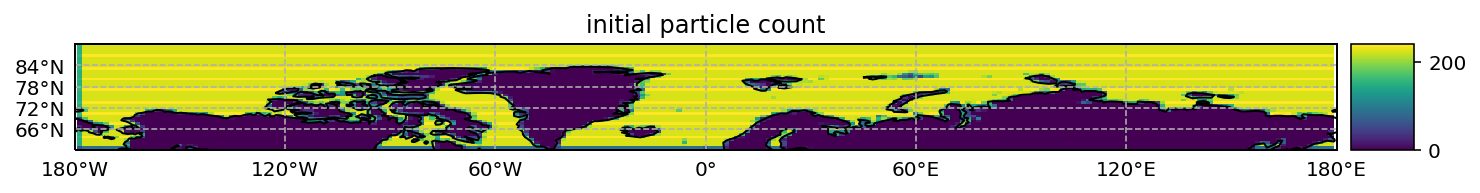

In [15]:
initCount = countG.countInit(particleG).T
plot.from_dataset(countG.lonarr, countG.latarr, initCount, latRange=(60,90), title='initial particle count', size=(12,4), export='initCount_refined.png')

In [ ]:
# ADVECTION TAKES PLACE HERE
# psetTest = gridAdvection(fieldset, countG, particleG, experiment_name='test')

In [ ]:
mytransmat = comtools.createTransition('/data/oceanparcels/output_data/data_Daan/pset_control_3590x590.nc', countG)
plt.matshow(mytransmat.data)
plt.show()

In [23]:
# Create network from numpy array (adjacency matrix)
G = nx.from_numpy_matrix(mytransmat.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G, 'out/graph_control_P3590x590_C240x40.net')

In [36]:
countG.load_communities('out/graph_control_P3590x590_C240x40.clu')

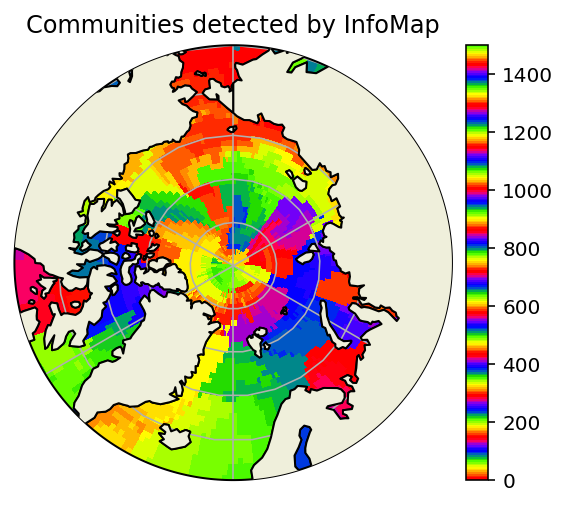

In [47]:
plot.from_dataset(countG.lonBounds, 
                  countG.latBounds, 
                  countG.community_map, 
                  colormap='prism', 
                  title='Communities detected by InfoMap',
                  polar=True, 
                  land=True, 
                  latRange=(60,90),
                  export='hr_communities_polar_land')

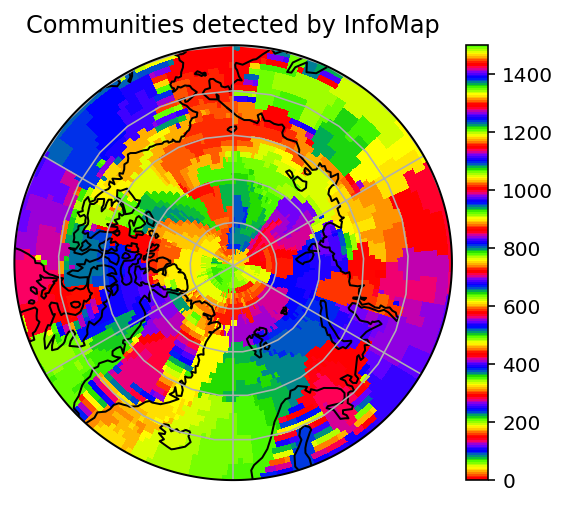

In [24]:
plot.from_dataset(countG.lonBounds, 
                  countG.latBounds, 
                  countG.community_map, 
                  colormap='prism', 
                  title='Communities detected by InfoMap',
                  polar=True, 
                  land=False, 
                  latRange=(60,90),
                  export='hr_communities_polar')

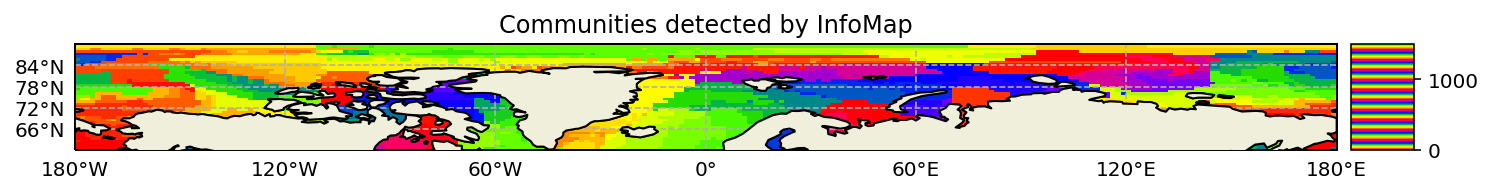

In [25]:
plot.from_dataset(countG.lonBounds, 
                  countG.latBounds, 
                  countG.community_map, 
                  title='Communities detected by InfoMap',
                  colormap='prism', 
                  land=True, 
                  latRange=(60,90), 
                  export="hr_communities_land.png", 
                  size=(12,4))

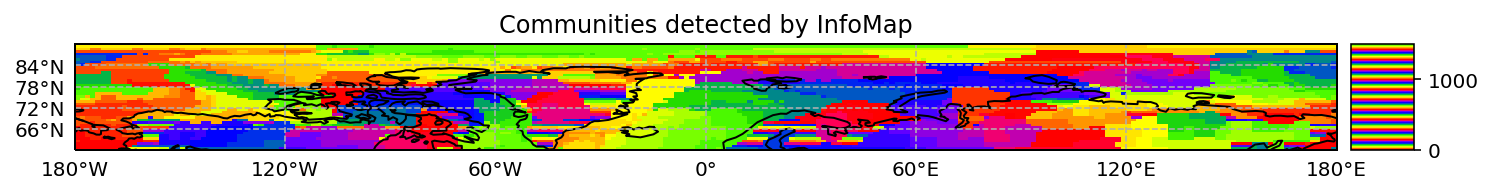

In [26]:
plot.from_dataset(countG.lonBounds, 
                  countG.latBounds, 
                  countG.community_map, 
                  title='Communities detected by InfoMap',
                  colormap='prism', 
                  land=False, 
                  latRange=(60,90), 
                  export="hr_communities.png", 
                  size=(12,4))